# Application of Machine Learning Techniques to Trading

This post is inspired by our observations of some common caveats and pitfalls during the competition when trying to apply ML techniques to trading problems.
Let’s look into how we can use ML to create a trade signal by data mining.

In [1]:
import numpy
import scipy
import sklearn
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

To setup an ML framework, We create features which could have some predictive power (X), a target variable that we’d like to predict(Y) and use historical data to train a ML model that can predict Y as close as possible to the actual value. Finally, we use this model to make predictions on new data where Y is unknown.

## Step 1: Setup your problem

We're going to use a problem from [QuantQuest](http://quant-quest.auquan.com/problem/qq2p1) for demo.
We are going to create a prediction model that predicts future expected value of basis, where:

$basis$ = Price of Stock - Price of Future

$basis_t=S_t−F_t$

$Y$ = future expected value of basis = $Average(basis_{(t+1)}, basis_{(t+2)}, basis_{(t+3)},basis_{(t+4)},basis_{(t+5)})$

*Note Y(t) will only be known during a backtest, but when using our model live, we won’t know Price(t+1) at time t. We make a prediction Y(Predicted,t) using our model and compare it with actual value only at time t+1. **This means you cannot use Y as a feature in your predictive model)** *

Since this is a regression problem, we will evaluate the model on RMSE. We’ll also use Total Pnl as an evaluation criterion

$RMSE = \sqrt{\sum{(Y_{actual} - Y_{predicted})^2} / n} $

Our Objective: Create a model so that predicted value is as close as possible to Y

## Step 2: Collect Reliable Data

We are using the folliwing data for our stock at minute interval data for trading days over one months(~8000 data points):
Stock Bid Price, Ask Price, Bid Volume, Ask Volume 
Future Bid Price, Ask Price, Bid Volume, Ask Volume
$Stock VWAP = {Bid Price*Ask Volume +  Ask Price*Bid Volume}/(Ask Volume +  Bid Volume)$
Future VWAP

Data is already cleaned for Dividends, Splits, Rolls

In [4]:
# Load the data
from backtester.dataSource.quant_quest_data_source import QuantQuestDataSource

cachedFolderName = '/Users/chandinijain/Auquan/qq2solver-data/historicalData/'
dataSetId = 'trainingData1'

instrumentIds = ['MQK']
ds = QuantQuestDataSource(cachedFolderName=cachedFolderName,
                                    dataSetId=dataSetId,
                                    instrumentIds=instrumentIds)


https://raw.githubusercontent.com/Auquan/auquan-historical-data/master/qq2Data/trainingData1/stock_list.txt
Processing data for stock: MQK
Processing instruments before beginning backtesting. This could take some time...


/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/backtester/dataSource/quant_quest_data_source.py:150: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



20% done...
40% done...
60% done...
80% done...


Auquan's Toolbox has downloaded and loaded the data into a dictionary of dataframes for you. We now need to prepare the data in a format we like.
The function `ds.getBookDataByFeature()` returns a dictionary of dataframes, one dataframe per feature. We create a new `data` dataframe for the stock with all the features. 

In [41]:
#Loading our data
def loadData(ds):
    data = None
    for key in ds.getBookDataByFeature().keys():
        if data is None:
            data = pd.DataFrame(np.nan, index = ds.getBookDataByFeature()[key].index, columns=[])
        data[key] = ds.getBookDataByFeature()[key]
    data['Stock Price'] =  ds.getBookDataByFeature()['stockTopBidPrice'] +\
                           ds.getBookDataByFeature()['stockTopAskPrice'] / 2.0
    data['Future Price'] = ds.getBookDataByFeature()['futureTopBidPrice'] +\
                           ds.getBookDataByFeature()['futureTopAskPrice'] / 2.0
    data['Y(Target)'] = ds.getBookDataByFeature()['basis'].shift(-5)
    del data['benchmark_score']
    del data['FairValue']
    return data

data = loadData(ds)

In [42]:
print(data.head(6))

                     futureTopAskVol  stockNextBidVol  stockTopBidVol  \
2017-01-06 09:17:00           2000.0            127.0            79.0   
2017-01-06 09:18:00           4000.0           2780.0            40.0   
2017-01-06 09:19:00           2000.0             10.0            81.0   
2017-01-06 09:20:00           2000.0             58.0           179.0   
2017-01-06 09:21:00           6000.0            100.0            68.0   
2017-01-06 09:22:00           2000.0            100.0          2299.0   

                     futureAverageBidPrice  futureNextBidPrice  \
2017-01-06 09:17:00                512.000              512.55   
2017-01-06 09:18:00                510.340              510.50   
2017-01-06 09:19:00                511.050              511.20   
2017-01-06 09:20:00                513.470              514.00   
2017-01-06 09:21:00                513.392              513.80   
2017-01-06 09:22:00                518.740              518.95   

                     futu

In [43]:
#Available data
for i in range(len(data.columns)):
    print(data.columns[i])

futureTopAskVol
stockNextBidVol
stockTopBidVol
futureAverageBidPrice
futureNextBidPrice
futureTopBidPrice
futureNextAskVol
futureAverageAskPrice
stockNextAskPrice
stockTotalBidVol
basis
stockAverageBidPrice
stockNextBidPrice
futureTopAskPrice
futureNextAskPrice
futureTotalBidVol
stockAverageAskPrice
stockNextAskVol
futureTotalAskVol
stockTopAskPrice
stockTotalAskVol
stockTopAskVol
futureVWAP
futureNextBidVol
stockTopBidPrice
stockVWAP
futureTopBidVol
Stock Price
Future Price
Y(Target)


## Step 3: Split Data

For this problem we have three datasets available, we will use one as training set, second as validation set and the third as our test set

In [44]:
# Training Data
dataSetId =  'trainingData1'
ds_training = QuantQuestDataSource(cachedFolderName=cachedFolderName,
                                    dataSetId=dataSetId,
                                    instrumentIds=instrumentIds)

training_data = loadData(ds_training)

# Validation Data
dataSetId =  'trainingData2'
ds_validation = QuantQuestDataSource(cachedFolderName=cachedFolderName,
                                    dataSetId=dataSetId,
                                    instrumentIds=instrumentIds)
validation_data = loadData(ds_validation)

# Test Data
dataSetId =  'trainingData3'
ds_test = QuantQuestDataSource(cachedFolderName=cachedFolderName,
                                    dataSetId=dataSetId,
                                    instrumentIds=instrumentIds)
out_of_sample_test_data = loadData(ds_test)

Processing data for stock: MQK
Processing instruments before beginning backtesting. This could take some time...
20% done...
40% done...
60% done...
80% done...
https://raw.githubusercontent.com/Auquan/auquan-historical-data/master/qq2Data/trainingData2/stock_list.txt
Processing data for stock: MQK
Processing instruments before beginning backtesting. This could take some time...
20% done...
40% done...
60% done...
80% done...
https://raw.githubusercontent.com/Auquan/auquan-historical-data/master/qq2Data/trainingData3/stock_list.txt
Processing data for stock: MQK
Processing instruments before beginning backtesting. This could take some time...
20% done...
40% done...
60% done...
80% done...


### Preparing Data

We add the target variable $Y$, defined as average of next five values of basis  

In [46]:
def prepareData(data, period):
    data['Y(Target)'] = data['basis'].rolling(period).mean().shift(-period)
    if 'FairValue' in data.columns:
        del data['FairValue']
    data.dropna(inplace=True)

period = 5
prepareData(training_data, period)
prepareData(validation_data, period)
prepareData(out_of_sample_test_data, period)

## Step 4: Feature Engineering

Let's try to create some features that may have some predictive power on our data.

*** The golden rule of feature selection is that the predictive power should come from primarily from the features and not from the model. You will find that the choice of features has a far greater impact on performance than the choice of model. *

We shouldn't randomly choose a very large set of features without exploring relationship with target variable, because little or no relationship with target variable will likely lead to overfitting.
The features might be highly correlated with each other, in that case a fewer number of features will explain the target just as well.

For this first iteration, we create a large number of features, using a mix of parameters. Later we will try to see if can reduce the number of features


In [47]:
def difference(dataDf, period):
    return dataDf.sub(dataDf.shift(period), fill_value=0)

def ewm(dataDf, halflife):
    return dataDf.ewm(halflife=halflife,ignore_na=False,min_periods=0,adjust=True).mean()

def rsi(data, period):
    data_upside = data.sub(data.shift(1), fill_value=0)
    data_downside = data_upside.copy()
    data_downside[data_upside > 0] = 0
    data_upside[data_upside < 0] = 0
    avg_upside = data_upside.rolling(period).mean()
    avg_downside = - data_downside.rolling(period).mean()
    rsi = 100 - (100 * avg_downside / (avg_downside + avg_upside))
    rsi[avg_downside == 0] = 100
    rsi[(avg_downside == 0) & (avg_upside == 0)] = 0

    return rsi

In [48]:
def create_features(data):
    basis_X = pd.DataFrame(index = data.index, columns =  [ 'emabasis3','emabasis5','emabasis2','emabasis7','emabasis10',\
                                                             'emabasis4','rsi15','rsi10','rsi5','mom1','mom10',\
                                                             'mom3','mom5'])
    
    basis_X['mom1'] = difference(data['basis'],2)
    basis_X['mom3'] = difference(data['basis'],4)
    basis_X['mom5'] = difference(data['basis'],6)
    basis_X['mom10'] = difference(data['basis'],11)

    basis_X['rsi15'] = rsi(data['basis'],15)
    basis_X['rsi10'] = rsi(data['basis'],10)
    basis_X['rsi5'] = rsi(data['basis'],5)
    
    basis_X['emabasis2'] = ewm(data['basis'],2)
    basis_X['emabasis3'] = ewm(data['basis'],3)
    basis_X['emabasis4'] = ewm(data['basis'],4)
    basis_X['emabasis5'] = ewm(data['basis'],5)
    basis_X['emabasis7'] = ewm(data['basis'],7)
    basis_X['emabasis10'] = ewm(data['basis'],10)

    basis_X['basis'] = data['basis']
    basis_X['vwapbasis'] = data['stockVWAP']-data['futureVWAP']
    
    basis_X['swidth'] = data['stockTopAskPrice']-data['stockTopBidPrice']
    basis_X['fwidth'] = data['futureTopAskPrice']-data['futureTopBidPrice']
    
    basis_X['btopask'] = data['stockTopAskPrice']-data['futureTopAskPrice']
    basis_X['btopbid'] =data['stockTopBidPrice']-data['futureTopBidPrice']
    basis_X['bavgask'] = data['stockAverageAskPrice']-data['futureAverageAskPrice']
    basis_X['bavgbid'] = data['stockAverageBidPrice']-data['futureAverageBidPrice']
    basis_X['bnextask'] = data['stockNextAskPrice']-data['futureNextAskPrice']
    basis_X['bnextbid'] = data['stockNextBidPrice']-data['futureNextBidPrice']
    basis_X['topaskvolratio'] = data['stockTopAskVol']/data['futureTopAskVol']
    basis_X['topbidvolratio'] = data['stockTopBidVol']/data['futureTopBidVol']
    basis_X['totalaskvolratio'] = data['stockTotalAskVol']/data['futureTotalAskVol']
    basis_X['totalbidvolratio'] = data['stockTotalBidVol']/data['futureTotalBidVol']
    basis_X['nextbidvolratio'] = data['stockNextBidVol']/data['futureNextBidVol']
    basis_X['nextaskvolratio'] = data['stockNextAskVol']-data['futureNextAskVol']
    
    basis_X['emabasisdi4'] = basis_X['emabasis7'] - basis_X['emabasis5'] + basis_X['emabasis2']
    basis_X['emabasisdi7'] = basis_X['emabasis7'] - basis_X['emabasis5']+ basis_X['emabasis3']
    basis_X['emabasisdi1'] = basis_X['emabasis10'] - basis_X['emabasis5'] + basis_X['emabasis3']
    basis_X['emabasisdi3'] = basis_X['emabasis10'] - basis_X['emabasis3']+ basis_X['emabasis5']
    basis_X['emabasisdi5'] = basis_X['emabasis7']- basis_X['emabasis5'] + data['basis']
    basis_X['emabasisdi'] = basis_X['emabasis5'] - basis_X['emabasis3'] + data['basis']
    basis_X['emabasisdi6'] = basis_X['emabasis7'] - basis_X['emabasis3']+ data['basis']
    basis_X['emabasisdi2'] = basis_X['emabasis10'] - basis_X['emabasis5']+ data['basis']
    basis_X['emabasisdi3'] = basis_X['emabasis10'] - basis_X['emabasis3']+ basis_X['emabasis5']
    
    basis_X = basis_X.fillna(0)
    
    basis_y = data['Y(Target)']
    basis_y.dropna(inplace=True)
    
    print("Any null data in y: %s, X: %s"%(basis_y.isnull().values.any(), basis_X.isnull().values.any()))
    print("Length y: %s, X: %s"%(len(basis_y.index), len(basis_X.index)))
    
    return basis_X, basis_y

In [49]:
basis_X_train, basis_y_train = create_features(training_data)
basis_X_test, basis_y_test = create_features(validation_data)

Any null data in y: False, X: False
Length y: 8737, X: 8737
Any null data in y: False, X: False
Length y: 6499, X: 6499


## Step 5: Model Selection

Let's start with a Linear Regression model with non-normalized features

In [50]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

def linear_regression(basis_X_train, basis_y_train, basis_X_test,basis_y_test):
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(basis_X_train, basis_y_train)
    # Make predictions using the testing set
    basis_y_pred = regr.predict(basis_X_test)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(basis_y_test, basis_y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

    # Plot outputs
    plt.scatter(basis_y_pred, basis_y_test,  color='black')
    plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

    plt.xlabel('Y(actual)')
    plt.ylabel('Y(Predicted)')

    plt.show()
    
    return regr, basis_y_pred

## Step 6: Train, Validate and Optimize (repeat steps 4-6)

Now we will try to itereate over various models, model parameters and feature space

('Coefficients: \n', array([ 1.91167944e+01,  1.89411016e+01,  4.70296769e+00,  5.87734586e+00,
        3.54035788e+00, -5.64856244e+01, -1.04179507e-03, -6.17734946e-04,
       -8.06451186e-05,  4.34472738e-02,  1.16561373e-02,  5.76295895e-02,
       -3.06296239e-02,  6.02523532e+00,  8.39921979e-02,  4.35365656e-03,
       -6.75947978e-03,  6.03079189e+00,  6.01967875e+00,  6.47918181e-02,
        5.72118514e-02,  2.84040654e-03,  1.58516454e-02, -7.61722002e-03,
       -7.64608079e-04, -3.88186244e-02,  3.12706435e-02,  3.41613781e-03,
       -1.31118404e-06, -8.36078810e+00,  6.05303858e+00,  3.71605060e+00,
        3.36466516e+00, -7.03852047e+00,  5.84954259e+00, -7.21421320e+00,
       -9.37550845e+00]))
Mean squared error: 0.02
Variance score: 0.96


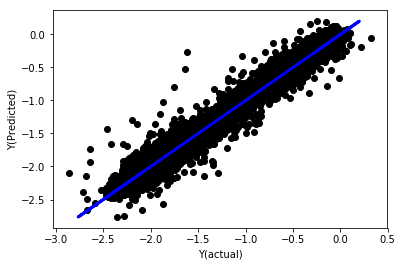

In [51]:
_, basis_y_pred = linear_regression(basis_X_train, basis_y_train, basis_X_test,basis_y_test)

Look at the model coeffecients. We can't really compare them or tell which ones are important since they all belong to different scale. Let's try normalization to conform them to same scale and also enforce some stationarity.

Normalization is generally tricky because future range of data is unknown. We overcome this by using rolling histrical mean and standard deviation over lookback period. However, this means the same normalized value of feature will mean different actual value at different times. This may be a cause of errors in your model; hence normalization is tricky and you have to figure what actually improves performance of your model(if at all).

In [52]:
def normalize(basis_X, basis_y, period):
    basis_X_norm = (basis_X - basis_X.rolling(period).mean())/basis_X.rolling(period).std()
    basis_X_norm.dropna(inplace=True)
    basis_y_norm = (basis_y - basis_X['basis'].rolling(period).mean())/basis_X['basis'].rolling(period).std()
    basis_y_norm = basis_y_norm[basis_X_norm.index]
    
    return basis_X_norm, basis_y_norm

('Coefficients: \n', array([-3.62562336e+00, -9.15274240e+00,  1.44465722e+00,  8.87792905e+00,
       -5.55687316e+00,  1.98323173e+01, -3.52677595e-03, -1.46185137e-02,
       -2.28603171e-02,  8.89158364e-03,  1.96775578e-02, -1.09431839e-03,
       -3.32224637e-03, -7.91656252e+00,  4.98693313e-02,  6.53834026e-03,
        1.12615956e-02,  2.08691443e+00,  2.03221946e+00,  9.75083631e-02,
        6.10888994e-02, -3.13066921e-02,  4.78554884e-02,  5.84281791e-04,
        1.12986615e-02, -2.19490620e-02,  2.31187541e-02,  5.69928897e-03,
       -5.78663706e-03,  3.02309761e+00, -2.45138755e+01,  1.00726718e+01,
        2.00852825e-02,  1.53648992e+01, -9.16940626e+00,  4.29745408e+00,
       -6.36285008e+00]))
Mean squared error: 0.28
Variance score: 0.77


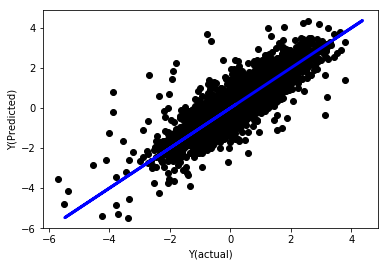

In [53]:
norm_period = 375
basis_X_norm_test, basis_y_norm_test = normalize(basis_X_test,basis_y_test, norm_period)
basis_X_norm_train, basis_y_norm_train = normalize(basis_X_train, basis_y_train, norm_period)

regr_norm, basis_y_pred = linear_regression(basis_X_norm_train, basis_y_norm_train, basis_X_norm_test, basis_y_norm_test)

The model doesn't seem to predict normalized $Y$ that well. We first convert prediction $Y$ back to unnormalized value to evaluate model

Mean squared error: 0.05
Variance score: 0.90


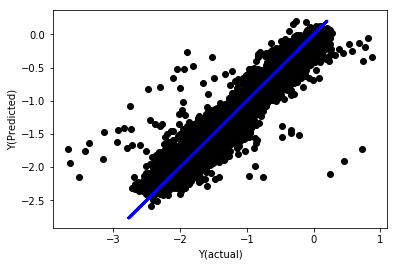

In [54]:
basis_y_pred = basis_y_pred * basis_X_test['basis'].rolling(period).std()[basis_y_norm_test.index] + basis_X_test['basis'].rolling(period).mean()[basis_y_norm_test.index]

print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test[basis_y_norm_test.index], basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test[basis_y_norm_test.index], basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test[basis_y_norm_test.index],  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

The model doesn't improve on the previous model, but it's not much worse either.And now we can actually compare coeffecients to see which features are actually important.

Let's look at the coeffecients

In [55]:
for i in range(len(basis_X_train.columns)):
    print('%.4f, %s'%(regr_norm.coef_[i], basis_X_train.columns[i]))

-3.6256, emabasis3
-9.1527, emabasis5
1.4447, emabasis2
8.8779, emabasis7
-5.5569, emabasis10
19.8323, emabasis4
-0.0035, rsi15
-0.0146, rsi10
-0.0229, rsi5
0.0089, mom1
0.0197, mom10
-0.0011, mom3
-0.0033, mom5
-7.9166, basis
0.0499, vwapbasis
0.0065, swidth
0.0113, fwidth
2.0869, btopask
2.0322, btopbid
0.0975, bavgask
0.0611, bavgbid
-0.0313, bnextask
0.0479, bnextbid
0.0006, topaskvolratio
0.0113, topbidvolratio
-0.0219, totalaskvolratio
0.0231, totalbidvolratio
0.0057, nextbidvolratio
-0.0058, nextaskvolratio
3.0231, emabasisdi4
-24.5139, emabasisdi7
10.0727, emabasisdi1
0.0201, emabasisdi3
15.3649, emabasisdi5
-9.1694, emabasisdi
4.2975, emabasisdi6
-6.3629, emabasisdi2


We can clearly see that some features have a much higher coeffecient compared to others, and probably have more predictive power.

Let's also look at correlation between different features.

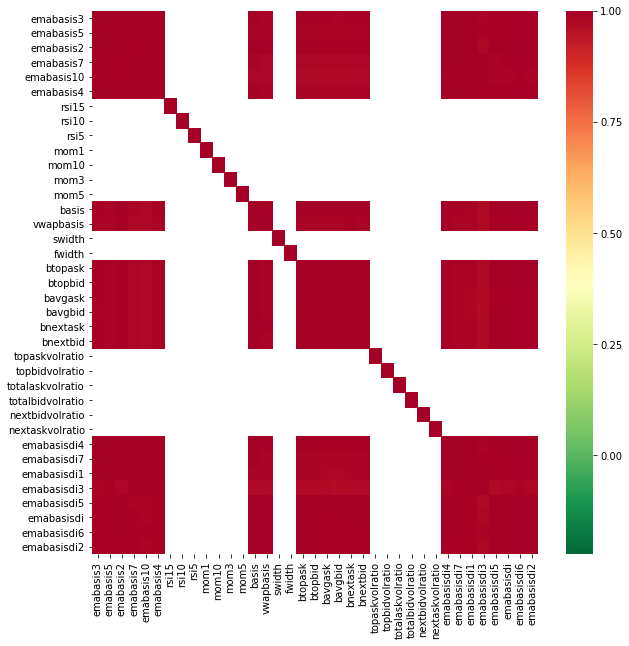

In [56]:
import seaborn

c = basis_X_train.corr()
plt.figure(figsize=(10,10))
seaborn.heatmap(c, cmap='RdYlGn_r', mask = (np.abs(c) <= 0.8))
plt.show()


The areas of dark red indicate highly correlated variables. Let's create/modify some features again and try to improve our model. 

For example, I can easily discard features line *emabasisdi7* that are just a linear combination of other features

In [57]:
def create_features_again(data):
    basis_X = pd.DataFrame(index = data.index, columns =  [])
    
#     basis_X['mom1'] = difference(data['basis'],2)
#     basis_X['mom3'] = difference(data['basis'],4)
#     basis_X['mom5'] = difference(data['basis'],6)
    basis_X['mom10'] = difference(data['basis'],11)

#     basis_X['rsi15'] = rsi(data['basis'],15)
#     basis_X['rsi10'] = rsi(data['basis'],10)
#     basis_X['rsi5'] = rsi(data['basis'],5)
    
    basis_X['emabasis2'] = ewm(data['basis'],2)
#     basis_X['emabasis3'] = ewm(data['basis'],3)
#     basis_X['emabasis4'] = ewm(data['basis'],4)
    basis_X['emabasis5'] = ewm(data['basis'],5)
#     basis_X['emabasis8'] = ewm(data['basis'],8)
    basis_X['emabasis10'] = ewm(data['basis'],10)

    basis_X['basis'] = data['basis']
#     basis_X['vwapbasis'] = data['stockVWAP']-data['futureVWAP']
    
#     basis_X['swidth'] = data['stockTopAskPrice']-data['stockTopBidPrice'] + (data['futureTopAskPrice']-data['futureTopBidPrice'])
    
#     basis_X['btopask'] = data['stockTopAskPrice']-data['futureTopAskPrice']
#     basis_X['btopbid'] =data['stockTopBidPrice']-data['futureTopBidPrice']
#     basis_X['bavgask'] = data['stockAverageAskPrice']-data['futureAverageAskPrice']
#     basis_X['bavgbid'] = data['stockAverageBidPrice']-data['futureAverageBidPrice']
#     basis_X['bnextask'] = data['stockNextAskPrice']-data['futureNextAskPrice']
#     basis_X['bnextbid'] = data['stockNextBidPrice']-data['futureNextBidPrice']
#     basis_X['topaskvolratio'] = data['stockTopAskVol']-data['futureTopAskVol']
#     basis_X['topbidvolratio'] = data['stockTopBidVol']-data['futureTopBidVol']
    basis_X['totalaskvolratio'] = (data['stockTotalAskVol']-data['futureTotalAskVol'])/100000
    basis_X['totalbidvolratio'] = (data['stockTotalBidVol']-data['futureTotalBidVol'])/100000
#     basis_X['nextbidvolratio'] = data['stockNextBidVol']-data['futureNextBidVol']
#     basis_X['nextaskvolratio'] = data['stockNextAskVol']-data['futureNextAskVol']
    
    basis_X = basis_X.fillna(0)
    
    basis_y = data['Y(Target)']
    basis_y.dropna(inplace=True)
    
    print("Any null data in y: %s, X: %s"%(basis_y.isnull().values.any(), basis_X.isnull().values.any()))
    print("Length y: %s, X: %s"%(len(basis_y.index), len(basis_X.index)))
    
    return basis_X, basis_y

Any null data in y: False, X: False
Length y: 6499, X: 6499
Any null data in y: False, X: False
Length y: 8737, X: 8737
('Coefficients: \n', array([-0.0067528 ,  0.52879292, -0.37816556,  0.2323171 ,  0.53062944,
       -0.01874965,  0.028642  ]))
Mean squared error: 0.28
Variance score: 0.77


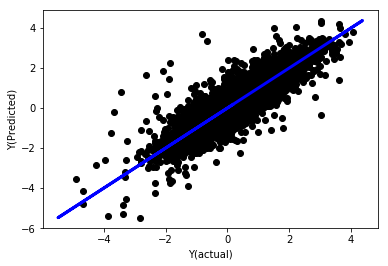

In [58]:
basis_X_test, basis_y_test = create_features_again(validation_data)
basis_X_train, basis_y_train = create_features_again(training_data)
norm_period = 375
basis_X_norm_test, basis_y_norm_test = normalize(basis_X_test,basis_y_test, norm_period)
basis_X_norm_train, basis_y_norm_train = normalize(basis_X_train, basis_y_train, norm_period)

regr_norm, basis_y_pred = linear_regression(basis_X_norm_train, basis_y_norm_train, basis_X_norm_test, basis_y_norm_test)


Mean squared error: 0.05
Variance score: 0.90


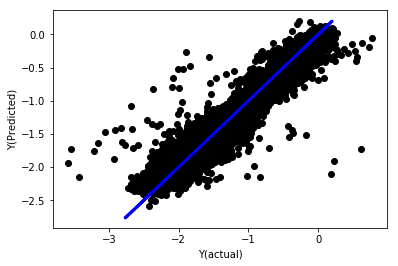

(-0.006752804064526399, 'mom10')
(0.5287929217358891, 'emabasis2')
(-0.37816555527188034, 'emabasis5')
(0.2323170952384813, 'emabasis10')
(0.5306294374732969, 'basis')
(-0.0187496487836021, 'totalaskvolratio')
(0.028641995632552864, 'totalbidvolratio')


In [59]:
basis_y_pred = basis_y_pred * basis_X_test['basis'].rolling(period).std()[basis_y_norm_test.index] + basis_X_test['basis'].rolling(period).mean()[basis_y_norm_test.index]

print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test[basis_y_norm_test.index], basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test[basis_y_norm_test.index], basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test[basis_y_norm_test.index],  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

for i in range(len(basis_X_train.columns)):
    print(regr_norm.coef_[i], basis_X_train.columns[i])

See, our model performance does not change, and we only need a few features to explain our target variable. I recommend playing with more features above, trying new combinations etc to see what can improve our model.

Let's go back to the non-normalized model, since normalization doesn't really help our model.

('Coefficients: \n', array([ 0.03249183,  0.49675487, -0.22289464,  0.2025182 ,  0.5080227 ,
       -0.21557005,  0.17128488]))
Mean squared error: 0.02
Variance score: 0.96


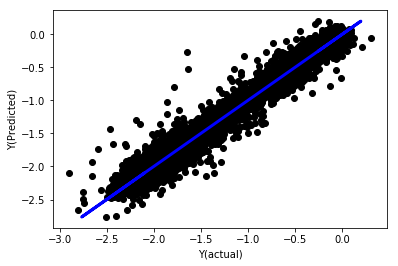

In [60]:
_, basis_y_pred = linear_regression(basis_X_train, basis_y_train, basis_X_test,basis_y_test)

basis_y_regr = basis_y_pred.copy()

You work more on the code above, try different combinations of features etc  to see what can improve our model.

We can also try more sophisticated models to see if change of model may improve performance

### K Nearest Neighbours

Mean squared error: 0.02
Variance score: 0.95


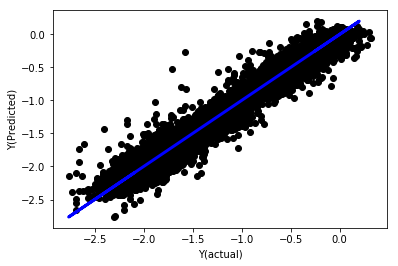

In [61]:
from sklearn import neighbors
n_neighbors = 5

model = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
model.fit(basis_X_train, basis_y_train)
basis_y_pred = model.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)

plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_knn = basis_y_pred.copy()

### SVR

Mean squared error: 0.02
Variance score: 0.95


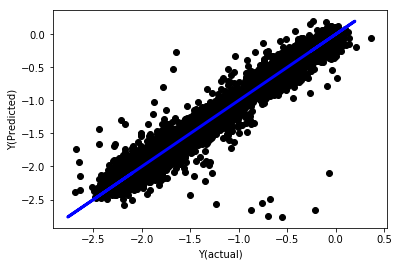

In [62]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1e3, gamma=0.1)

model.fit(basis_X_train, basis_y_train)
basis_y_pred = model.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_svr = basis_y_pred.copy()

### Decision Trees

Mean squared error: 0.02
Variance score: 0.95


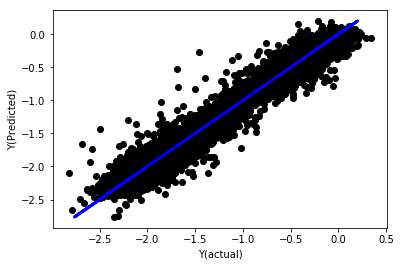

In [63]:
from sklearn import ensemble
model=ensemble.ExtraTreesRegressor()
model.fit(basis_X_train, basis_y_train)
basis_y_pred = model.predict(basis_X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

basis_y_trees = basis_y_pred.copy()

### Ensemble Method

We could try averaging predictions from all of the above methods to make our final prediction. Some models may work well in prediction certain scenarios and other in prediction other scenarios. Or a model may be extremely overfitting in a certain scenario. Aggregating predictions from different models can reduce error and overfitting, with errors from different models likely getting cancelled out or reduced. 

One simple way is to simply average the predictions. Other common ensemble methods are Bagging and Boosting.


In [64]:
basis_y_pred_ensemble = (basis_y_trees + basis_y_svr + +basis_y_knn + basis_y_regr)/4

Mean squared error: 0.02
Variance score: 0.95


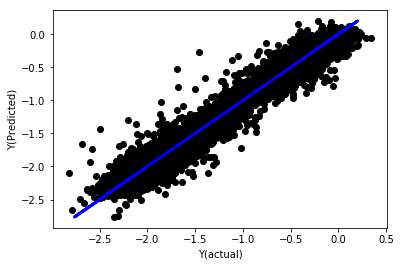

In [65]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(basis_y_test, basis_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(basis_y_test, basis_y_pred))

# Plot outputs
plt.scatter(basis_y_pred, basis_y_test,  color='black')
plt.plot(basis_y_test, basis_y_test, color='blue', linewidth=3)


plt.xlabel('Y(actual)')
plt.ylabel('Y(Predicted)')

plt.show()

Note thatI have only mentioned a few common models here. You should try feature egineering with each of them and also play with model parameters to further optimize.

You loop over this stage multiple times till you finally have a model that you’re happy with. Only when you have a model who’s performance you like, proceed to the next step.

## Step 7: Backtest on Test Data

Finally I backtest performance of our final, optimized model from last step on that Test Data that we had kept aside at the start and did not touch yet.
This provides you with realistic expectation of how your model is expected to perform on new and unseen data when you start trading live. Hence, it is necessary to ensure you have a clean dataset that you haven’t used to train or validate your model.

We're going to choose our linear regression model as our final model of choice. For this purpose, I'm going to use Auquan’s [python based free and open source toolbox](https://bitbucket.org/auquan/auquantoolbox). You can install it via pip: 

`pip install -U auquan_toolbox`

In [66]:
import backtester
from backtester.features.feature import Feature
from backtester.trading_system import TradingSystem
from backtester.sample_scripts.fair_value_params import FairValueTradingParams

In [67]:
class Problem1Solver():

    def getTrainingDataSet(self):
        return "trainingData1"

    def getSymbolsToTrade(self):
        return ['MQK']

    def getCustomFeatures(self):
        return {'my_custom_feature': MyCustomFeature}

    def getFeatureConfigDicts(self):
                            
        expma5dic = {'featureKey': 'emabasis5',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 5,
                              'featureName': 'basis'}}
        expma10dic = {'featureKey': 'emabasis10',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 10,
                              'featureName': 'basis'}}                     
        expma2dic = {'featureKey': 'emabasis2',
                 'featureId': 'exponential_moving_average',
                 'params': {'period': 2,
                              'featureName': 'basis'}}
        mom10dic = {'featureKey': 'mom10',
                 'featureId': 'difference',
                 'params': {'period': 11,
                              'featureName': 'basis'}}
        
        return [expma5dic,expma2dic,expma10dic,mom10dic]    
    
    def getFairValue(self, updateNum, time, instrumentManager):
        # holder for all the instrument features
        lbInstF = instrumentManager.getLookbackInstrumentFeatures()
        mom10 = lbInstF.getFeatureDf('mom10').iloc[-1]
        emabasis2 = lbInstF.getFeatureDf('emabasis2').iloc[-1]
        emabasis5 = lbInstF.getFeatureDf('emabasis5').iloc[-1]
        emabasis10 = lbInstF.getFeatureDf('emabasis10').iloc[-1] 
        basis = lbInstF.getFeatureDf('basis').iloc[-1]
        totalaskvol = lbInstF.getFeatureDf('stockTotalAskVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalAskVol').iloc[-1]
        totalbidvol = lbInstF.getFeatureDf('stockTotalBidVol').iloc[-1] - lbInstF.getFeatureDf('futureTotalBidVol').iloc[-1]
        
        coeff = [ 0.03249183, 0.49675487, -0.22289464, 0.2025182, 0.5080227, -0.21557005, 0.17128488]
        newdf = 0*basis
        newdf['MQK'] = coeff[0] * mom10['MQK'] + coeff[1] * emabasis2['MQK'] +\
                      coeff[2] * emabasis5['MQK'] + coeff[3] * emabasis10['MQK'] +\
                      coeff[4] * basis['MQK'] + coeff[5] * totalaskvol['MQK']+\
                      coeff[6] * totalbidvol['MQK']
                    
        newdf.fillna(emabasis5,inplace=True)
        return newdf 

class MyCustomFeature(Feature):
    ''''
    Custom Feature to implement for instrument. This function would return the value of the feature you want to implement.
    '''
    @classmethod
    def computeForInstrument(cls, updateNum, time, featureParams, featureKey, instrumentManager):
        # Custom parameter which can be used as input to computation of this feature
        instrumentLookbackData = instrumentManager.getlbInstF()
        data = instrumentLookbackData.getFeatureDf(featureKey)
        if len(data.index) >= 1:
            prev_ema = data.iloc[-1]
        else:
            prev_ema = instrumentLookbackData.getFeatureDf(featureParams['featureName']).iloc[-1]
        halflife = featureParams['period']
        alpha = 2/(halflife+1)
        avg = instrumentLookbackData.getFeatureDf(featureParams['featureName']).iloc[-1] * alpha + prev_ema * (1 - alpha)
        return avg


In [18]:
problem1Solver = Problem1Solver()
tsParams = FairValueTradingParams(problem1Solver)
tradingSystem = TradingSystem(tsParams)
tradingSystem.startTrading(onlyAnalyze=False, 
                           shouldPlot=True, makeInstrumentCsvs=False)

Processing data for stock: MQK
Processing instruments before beginning backtesting. This could take some time...
20% done...
40% done...
60% done...
80% done...
2017-01-06 09:17:00
2017-01-06 09:18:00
2017-01-06 09:19:00
2017-01-06 09:20:00
2017-01-06 09:21:00
2017-01-06 09:22:00
2017-01-06 09:23:00
2017-01-06 09:24:00
2017-01-06 09:25:00
2017-01-06 09:26:00
2017-01-06 09:27:00
2017-01-06 09:28:00
2017-01-06 09:29:00
2017-01-06 09:30:00
2017-01-06 09:31:00
2017-01-06 09:32:00
2017-01-06 09:33:00
2017-01-06 09:34:00
2017-01-06 09:35:00
2017-01-06 09:36:00
2017-01-06 09:37:00
2017-01-06 09:38:00
2017-01-06 09:39:00
2017-01-06 09:40:00
2017-01-06 09:41:00
2017-01-06 09:42:00
2017-01-06 09:43:00
2017-01-06 09:44:00
2017-01-06 09:45:00
2017-01-06 09:46:00
2017-01-06 09:47:00
2017-01-06 09:48:00
2017-01-06 09:49:00
2017-01-06 09:50:00
2017-01-06 09:51:00
2017-01-06 09:52:00
2017-01-06 09:53:00
2017-01-06 09:54:00
2017-01-06 09:55:00
2017-01-06 09:56:00
2017-01-06 09:57:00
2017-01-06 09:58:00

{'dates': array(['2017-01-06T09:00:00.000000000', '2017-01-06T10:00:00.000000000',
        '2017-01-06T11:00:00.000000000', '2017-01-06T12:00:00.000000000',
        '2017-01-06T13:00:00.000000000', '2017-01-06T14:00:00.000000000',
        '2017-01-06T15:00:00.000000000', '2017-01-09T09:00:00.000000000',
        '2017-01-09T10:00:00.000000000', '2017-01-09T11:00:00.000000000',
        '2017-01-09T12:00:00.000000000', '2017-01-09T13:00:00.000000000',
        '2017-01-09T14:00:00.000000000', '2017-01-09T15:00:00.000000000',
        '2017-01-10T09:00:00.000000000', '2017-01-10T10:00:00.000000000',
        '2017-01-10T11:00:00.000000000', '2017-01-10T12:00:00.000000000',
        '2017-01-10T13:00:00.000000000', '2017-01-10T14:00:00.000000000',
        '2017-01-10T15:00:00.000000000', '2017-01-11T09:00:00.000000000',
        '2017-01-11T10:00:00.000000000', '2017-01-11T11:00:00.000000000',
        '2017-01-11T12:00:00.000000000', '2017-01-11T13:00:00.000000000',
        '2017-01-11T14:00:00.

It is important to remember that if you don’t like the results of your backtest on test data, discard the model and start again. DO NOT go back and re-optimize your model, this will lead to over fitting! (Also recommend to create a new test data set, since this one is now tainted; in discarding a model, we implicitly know something about the dataset).